In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('onlinefraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data.shape

(6362620, 11)

# PRE-PROCESSING

In [6]:
df = data.copy()

## Creation of Subsets (Following the EDA)

In [7]:
origineBalance_columns = ['oldbalanceOrg', 'newbalanceOrig']
destinationBalance_columns = ['oldbalanceDest', 'newbalanceDest']

In [8]:
key_columns = ['step', 'type', 'amount', 'isFraud']

In [9]:
df = df[key_columns + origineBalance_columns + destinationBalance_columns]
df.head()

,step,type,amount,isFraud,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,0,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,1864.28,0,21249.0,19384.72,0.0,0.0
2,1,TRANSFER,181.00,1,181.0,0.00,0.0,0.0
3,1,CASH_OUT,181.00,1,181.0,0.00,21182.0,0.0
4,1,PAYMENT,11668.14,0,41554.0,29885.86,0.0,0.0


## Train-Test Split - Cleaning - Encoding


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [12]:
testset['isFraud'].value_counts()

isFraud
0    1270883
1       1641
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

In [14]:
def encoding(df):
    onhot_encoder  = OneHotEncoder()
    one_encoded = onhot_encoder.fit_transform(df[['type']]).toarray()
    type_encoded_df = pd.DataFrame(one_encoded, 
                                  columns=onhot_encoder.get_feature_names_out(['type']),index=df.index)
    

    df = pd.concat([df.drop('type', axis=1), type_encoded_df], axis=1)


    return df
    

In [15]:
encoding(df).head()

,step,amount,isFraud,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,170136.0,160296.36,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,0,21249.0,19384.72,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,1,181.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,1,181.0,0.00,21182.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,0,41554.0,29885.86,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
def preprocessing(df):


    df= encoding(df)


    y = df['isFraud']
    X = df.drop('isFraud', axis=1)

 

    print(y.value_counts())

    return X, y

In [17]:
X_train , y_train = preprocessing(trainset)

print(y_train.shape)



isFraud
0    5083524
1       6572
Name: count, dtype: int64
(5090096,)


In [18]:
X_test, y_test = preprocessing(testset)

isFraud
0    1270883
1       1641
Name: count, dtype: int64


## Modeling


In [19]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier



In [20]:

nonfraud, fraud=y_train.value_counts()
scale = nonfraud / fraud

In [21]:
DecisionTree = DecisionTreeClassifier(random_state=0)
RandomForest = RandomForestClassifier(class_weight='balanced',random_state=0)
Xgb = XGBClassifier(scale_pos_weight=scale, random_state=0)


In [22]:
list_of_models = {
                  "DecisionTree":DecisionTree,
                  "RandomForest":RandomForest, 
                  "xgboost":Xgb, 
                  }

In [23]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [24]:
def evaluation(model):

    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))


    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4 ,
                                               train_sizes=np.linspace(0.1, 1, 5),
                                               scoring='f1')
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='Validation score')
    plt.legend()

DecisionTree
[[1270715     168]
 [    204    1437]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.90      0.88      0.89      1641

    accuracy                           1.00   1272524
   macro avg       0.95      0.94      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

RandomForest
[[1270861      22]
 [    356    1285]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.98      0.78      0.87      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

xgboost
[[1268952    1931]
 [     17    1624]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.46      0.99      0.63      1641

    accuracy                   

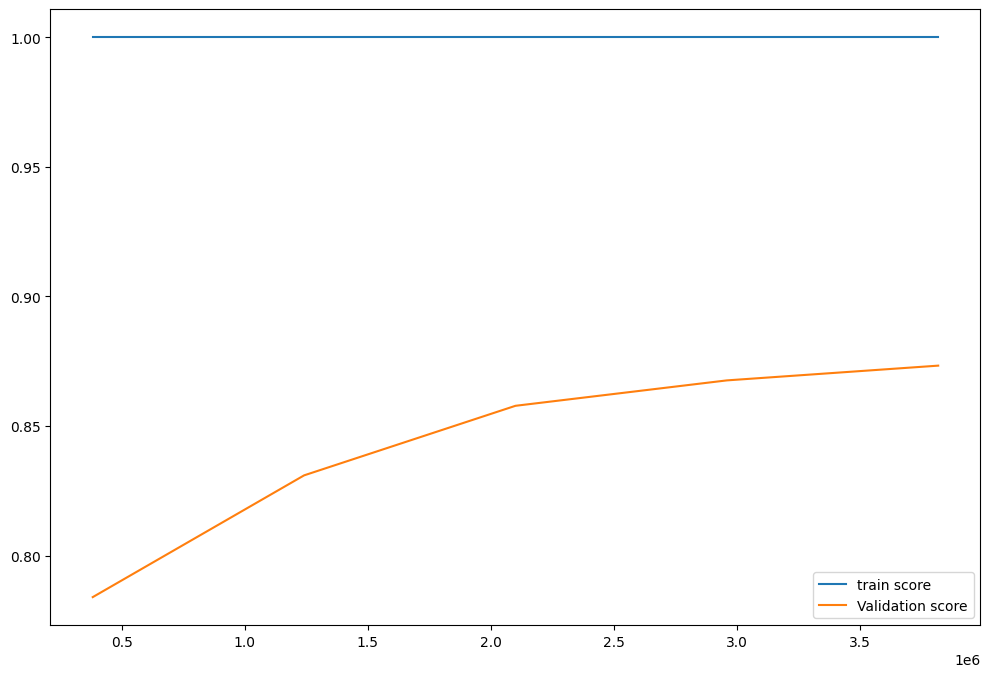

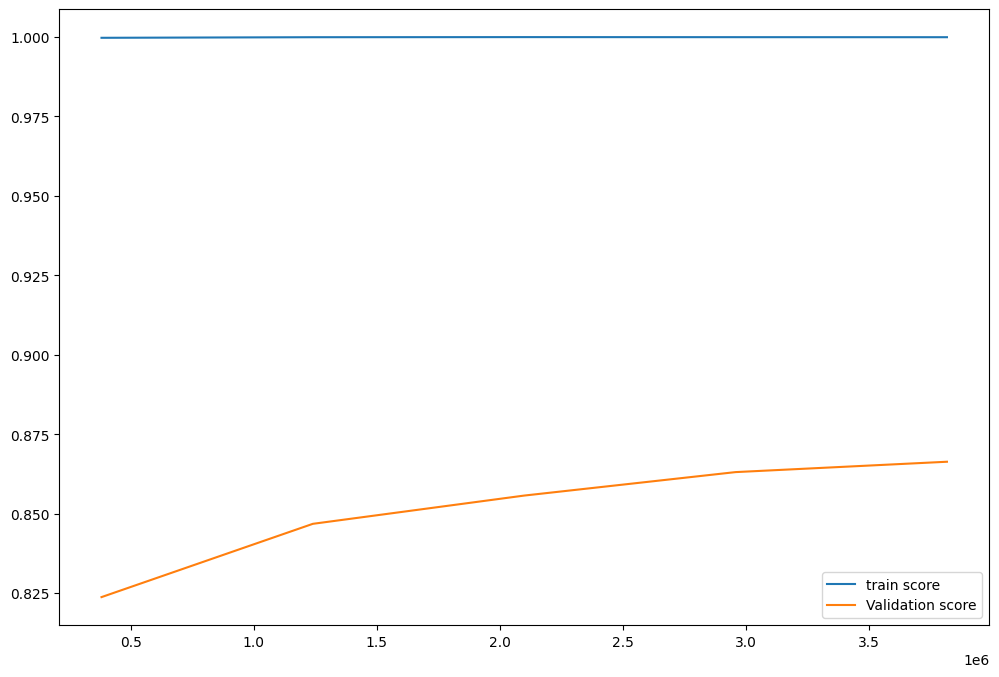

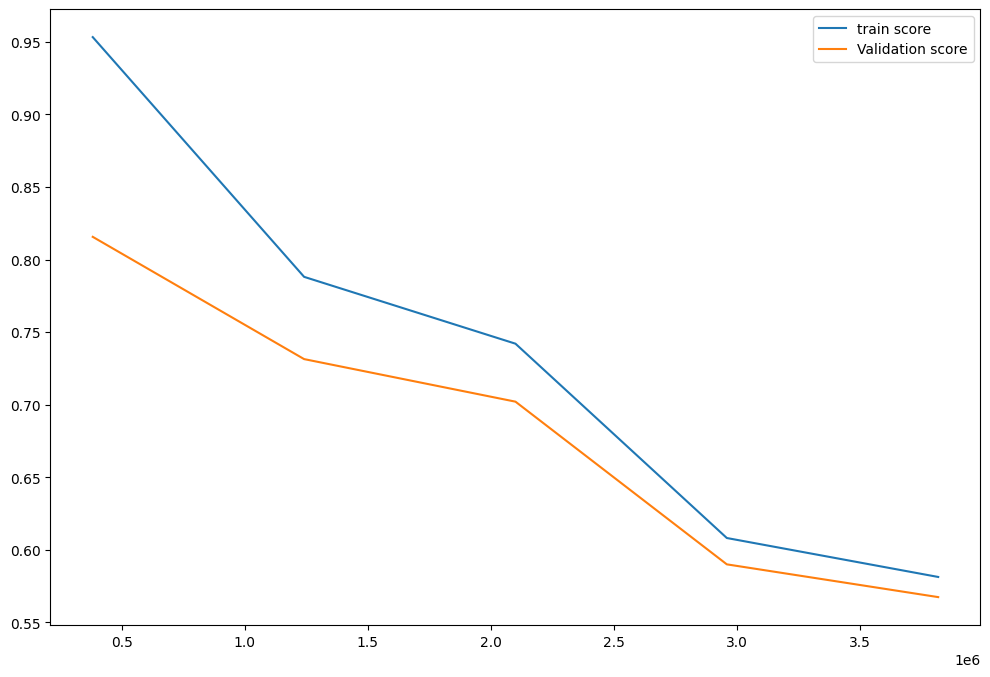

In [25]:
for name, model in list_of_models.items():
    print(name)
    evaluation(model)

## Optimisation

In [23]:
RandomForest.__repr__

<bound method BaseEstimator.__repr__ of RandomForestClassifier(class_weight='balanced', random_state=0)>

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
hyper_params = {
    'n_estimators': [200],
    'max_depth': [10, 20, 30, None],
}

In [31]:
random_search = RandomizedSearchCV(
    estimator=RandomForest,
    param_distributions=hyper_params,
    n_iter=4,            
    scoring='f1_macro',   # Choisir une métrique qui reflète vos objectifs, ici f1_macro pour équilibrer les classes
    cv=3,                 # Utilisez une validation croisée stratifiée si possible
    random_state=0,    
   
)

In [32]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_iter=4,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'n_estimators': [200]},
                   random_state=0, scoring='f1_macro')

In [36]:
random_search.best_score_
model = random_search.best_estimator_

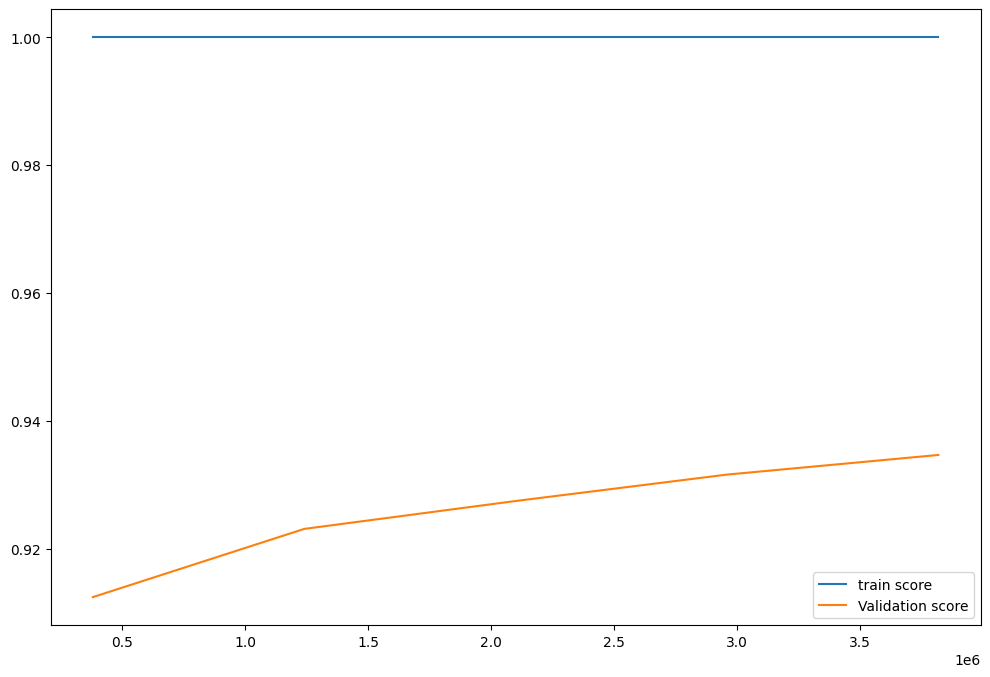

In [39]:
N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4 ,
                                               train_sizes=np.linspace(0.1, 1, 5),
                                               scoring="f1_macro")
    
plt.figure(figsize=(12,8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='Validation score')
plt.legend()

In [ ]:
hyper_params = {
    'n_estimators': [500, 600],
    'max_depth': [30, 40, None],
}

In [32]:
random_search = RandomizedSearchCV(
    estimator=RandomForest,
    param_distributions=hyper_params,
    n_iter=6,            
    scoring='f1_macro',   # Choisir une métrique qui reflète vos objectifs, ici f1_macro pour équilibrer les classes
    cv=3,                 # Utilisez une validation croisée stratifiée si possible
    random_state=0,    
   
)

In [33]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_iter=6,
                   param_distributions={'max_depth': [30, 40, None],
                                        'n_estimators': [500, 600]},
                   random_state=0, scoring='f1_macro')

In [35]:
random_search.best_params_

{'n_estimators': 500, 'max_depth': 30}

In [43]:
random_search.best_params_


{'n_estimators': 500, 'max_depth': 30}

In [47]:
random_search.best_score_

np.float64(0.9395877337584135)

In [ ]:
hyper_params = {
    'n_estimators': [200],
    'max_depth': [30],
    'max_features': ['sqrt', 'log2'] + list(np.linspace(0.1, 1.0, num=5)),
}

In [50]:
random_search = RandomizedSearchCV(
    estimator=RandomForest,
    param_distributions=hyper_params,
    n_iter=6,            
    scoring='f1_macro',   
    cv=3,                 
    random_state=0,    
)

In [51]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_iter=6,
                   param_distributions={'max_depth': [30],
                                        'max_features': ['sqrt', 'log2',
                                                         np.float64(0.1),
                                                         np.float64(0.325),
                                                         np.float64(0.55),
                                                         np.float64(0.775),
                                                         np.float64(1.0)],
                                        'n_estimators': [200]},
                   random_state=0, scoring='f1_macro')

In [52]:
random_search.best_score_

np.float64(0.9414364374116951)

In [54]:
random_search.best_params_

{'n_estimators': 200, 'max_features': np.float64(1.0), 'max_depth': 30}

In [ ]:
hyper_params = {
    'n_estimators': [500],
    'max_depth': [30],
    'max_features': ['sqrt', 'log2'] + list(np.linspace(0.1, 1.0, num=8)),
}

In [57]:
random_search = RandomizedSearchCV(
    estimator=RandomForest,
    param_distributions=hyper_params,
    n_iter=10,            
    scoring='f1_macro',   
    cv=3,                 
    random_state=0,    
)

In [58]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   param_distributions={'max_depth': [30],
                                        'max_features': ['sqrt', 'log2',
                                                         np.float64(0.1),
                                                         np.float64(0.2285714285714286),
                                                         np.float64(0.3571428571428572),
                                                         np.float64(0.48571428571428577),
                                                         np.float64(0.6142857142857143),
                                                         np.float64(0.7428571428571429),
                                                         np.float64(0.8714285714285716),
                                                         np.float64(1.0)],
                                        'n_estimators': [500]},
                   random_state=0, scoring='f1_macro')

In [60]:
random_search.best_params_

{'n_estimators': 500,
 'max_features': np.float64(0.8714285714285716),
 'max_depth': 30}

In [61]:
random_search.best_score_

np.float64(0.9416506469403125)